Loading and processing data

(200, 200)


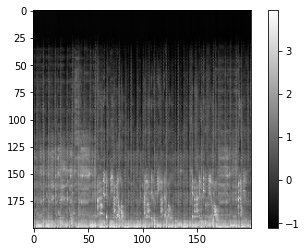

In [34]:
import numpy as np
from matplotlib import pyplot as plt
from help import show_image_from_each_class, label_to_genre
import random
import pandas as pd
from sklearn import preprocessing

images_original = np.load("../data/processed/images.npy")
labels = np.load("../data/processed/labels.npy")

use_n_genres = 4
images_original = images_original[:100 * use_n_genres]

labels = labels[:100 * use_n_genres,:use_n_genres]
input_shape = images_original.shape[1:]
print(input_shape)


scaler = preprocessing.StandardScaler()
images = scaler.fit_transform(images_original.reshape(-1, images_original.shape[-1])).reshape(images_original.shape)

plt.imshow(images[60], cmap="gray")
plt.colorbar()
plt.show()

# Normalizing the dataset
# flattened_images = images_original.flatten()
# images = images_original - flattened_images.mean()

In [35]:
show_image_from_each_class(images, use_n_genres)

TypeError: show_image_from_each_class() takes 1 positional argument but 2 were given

In [36]:
from sklearn.model_selection import train_test_split

# Splitting data into train and test set
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=1.0/3)
print("Train set length:" + str(len(x_train)))
print("Validation set length:" + str(len(x_valid)))
print("Test set length:" + str(len(x_test)))


Train set length:280
Validation set length:80
Test set length:40


Describing the model

In [72]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, GlobalAveragePooling2D

num_classes = use_n_genres
inputs = Input(shape=(input_shape + (1,))) # Nicer way to add this 1 as a dimension?

# lamda is the weight of the L2 penalty term
lamda = 0.15
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeUniform()


# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = Conv2D(8, kernel_size=(3, 3), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3))(x)
x = Dropout(0.5)(x)

x = Conv2D(8, kernel_size=(3, 3), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3))(x)
x = Dropout(0.5)(x)

x = Conv2D(8, kernel_size=(3, 3), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3))(x)
x = Dropout(0.5)(x)


encoded = Flatten()(x)

x = Dense(4,kernel_regularizer=L2_regularizer)(encoded)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model = Model(inputs=inputs, outputs=predictions)

model.summary()
# ********************************************* Model ********************************************

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 200, 200, 1)]     0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 198, 198, 8)       80        
_________________________________________________________________
batch_normalization_53 (Batc (None, 198, 198, 8)       32        
_________________________________________________________________
activation_67 (Activation)   (None, 198, 198, 8)       0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 66, 66, 8)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 64, 64, 8)         584       
_________________________________________________________________
batch_normalization_54 (Batc (None, 64, 64, 8)         32 

In [49]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(current)
        if len(self.losses) < 5: # We only consider learning rate decrease after 5 epochs since the last decrease.
            print(" lr: {:.6f}".format(lr) )
            return
        if len(self.losses) > 5:
            self.losses.pop(0)
        scheduled_lr = self.schedule(lr,self.losses)
        if lr != scheduled_lr:
            self.losses = [] # We empty the loss array after we decreased the learning rate.
        tf.keras.backend.set_value(self.model.optimizer.lr, 
        scheduled_lr)
        print(" lr: {:.6f}".format(scheduled_lr) )      

def lr_schedule(lr, losses):
    mean = sum(losses[:len(losses)-1]) / len(losses[:len(losses)-1])
    last_loss = losses[-1]
    if last_loss >= mean*0.9: # If there is not at least 10% improvent regarding the mean of the previous losses, than we decrease.
        lr = lr/2
    return lr

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)

In [77]:

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
              metrics=['accuracy'])


In [78]:
print(x_valid.shape, y_valid.shape)

history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(x_valid, y_valid),
          shuffle=True,
          callbacks=[CustomLearningRateScheduler(lr_schedule),early_stopping_callback]
        )

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(80, 200, 200) (80, 4)
Epoch 1/100
9/9 [==============================] - 4s 360ms/step - loss: 0.8068 - accuracy: 0.8108 - val_loss: 2.5818 - val_accuracy: 0.2500
 lr: 0.010000
Epoch 2/100
9/9 [==============================] - 3s 323ms/step - loss: 0.8317 - accuracy: 0.7879 - val_loss: 1.9200 - val_accuracy: 0.2875
 lr: 0.010000
Epoch 3/100
9/9 [==============================] - 3s 329ms/step - loss: 0.8445 - accuracy: 0.7911 - val_loss: 3.3935 - val_accuracy: 0.2500
 lr: 0.010000
Epoch 4/100
9/9 [==============================] - 3s 317ms/step - loss: 0.8836 - accuracy: 0.8197 - val_loss: 3.5080 - val_accuracy: 0.2500
 lr: 0.010000
Epoch 5/100
9/9 [==============================] - 3s 319ms/step - loss: 0.8881 - accuracy: 0.8102 - val_loss: 3.2135 - val_accuracy: 0.2875
 lr: 0.005000
Epoch 6/100
9/9 [==============================] - 3s 322ms/step - loss: 0.8488 - accuracy: 0.8327 - val_loss: 2.9669 - val_accuracy: 0.2500
 lr: 0.005000
Epoch 7/100
9/9 [==============================

In [36]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

num_classes = 10
inputs = Input(shape=(input_shape + (1,))) # Nicer way to add this 1 as a dimension?

# lamda is the weight of the L2 penalty term
lamda = 0.01                  # IS THIS A GOOD VALUE?
L2_regularizer = keras.regularizers.l2(lamda)
initializer = tf.keras.initializers.HeNormal()


# ********************************************* Model ********************************************
# Encoder (convolutional base)
x = Conv2D(16, kernel_size=(5,5), kernel_regularizer=L2_regularizer,  kernel_initializer=initializer)(inputs)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, kernel_size=(5,5),kernel_regularizer=L2_regularizer)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)

encoded = Flatten()(x)

# Decoder (2 fully connected layers)
x = Dense(32,kernel_regularizer=L2_regularizer)(encoded)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes,activation='softmax')(x)

# This creates a callable model that includes the Input layer and the prediction layer
model2 = Model(inputs=inputs, outputs=predictions)

model2.summary()
# ********************************************* Model ********************************************

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 196, 196, 16)      416       
                                                                 
 activation_12 (Activation)  (None, 196, 196, 16)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 196, 196, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 98, 98, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 16)        6416

In [49]:
class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.losses = []

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.losses.append(current)
        if len(self.losses) < 5: # We only consider learning rate decrease after 5 epochs since the last decrease.
            print(" lr: {:.6f}".format(lr) )
            return
        if len(self.losses) > 5:
            self.losses.pop(0)
        scheduled_lr = self.schedule(lr,self.losses)
        if lr != scheduled_lr:
            self.losses = [] # We empty the loss array after we decreased the learning rate.
        tf.keras.backend.set_value(self.model.optimizer.lr, 
        scheduled_lr)
        print(" lr: {:.6f}".format(scheduled_lr) )      

def lr_schedule(lr, losses):
    mean = sum(losses[:len(losses)-1]) / len(losses[:len(losses)-1])
    last_loss = losses[-1]
    if last_loss >= mean*0.9: # If there is not at least 10% improvent regarding the mean of the previous losses, than we decrease.
        lr = lr/2
    return lr

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12,restore_best_weights=True)

In [40]:
model2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=0.02, nesterov=True),
              metrics=['accuracy'])

In [41]:
history2 = model2.fit(x_train, y_train,
          batch_size=32,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[CustomLearningRateScheduler(lr_schedule),early_stopping_callback])

score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/100
25/25 [==============================] - 21s 803ms/step - loss: 3.5669 - accuracy: 0.2488 - val_loss: 8.9093 - val_accuracy: 0.2000
Epoch 2/100
25/25 [==============================] - 23s 917ms/step - loss: 3.1450 - accuracy: 0.3375 - val_loss: 4.8124 - val_accuracy: 0.1850
Epoch 3/100
25/25 [==============================] - 20s 818ms/step - loss: 2.8865 - accuracy: 0.4013 - val_loss: 6.2418 - val_accuracy: 0.1900
Epoch 4/100
25/25 [==============================] - 21s 833ms/step - loss: 2.8836 - accuracy: 0.4200 - val_loss: 3.4801 - val_accuracy: 0.3450
Epoch 5/100
25/25 [==============================] - 21s 842ms/step - loss: 2.5972 - accuracy: 0.5263 - val_loss: 3.1039 - val_accuracy: 0.3050
Epoch 6/100
25/25 [==============================] - 21s 827ms/step - loss: 2.4411 - accuracy: 0.6037 - val_loss: 79.5271 - val_accuracy: 0.0550
Epoch 7/100
25/25 [==============================] - 21s 824ms/step - loss: 2.5394 - accuracy: 0.5562 - val_loss: 6.9505 - val_accuracy

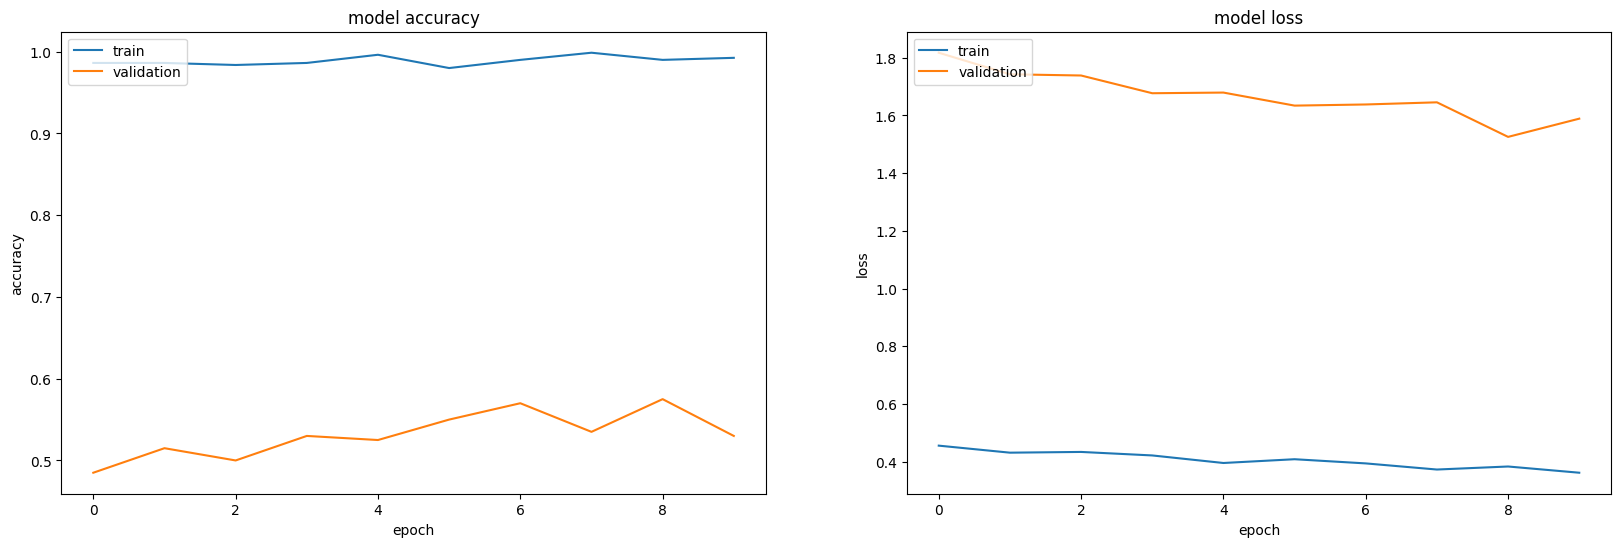

In [32]:
def show_history(history):
  plt.figure(figsize=(20,6))

  # summarize history for accuracy
  plt.subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')

  # summarize history for loss
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

show_history(history)

(7, 7, 1, 16)


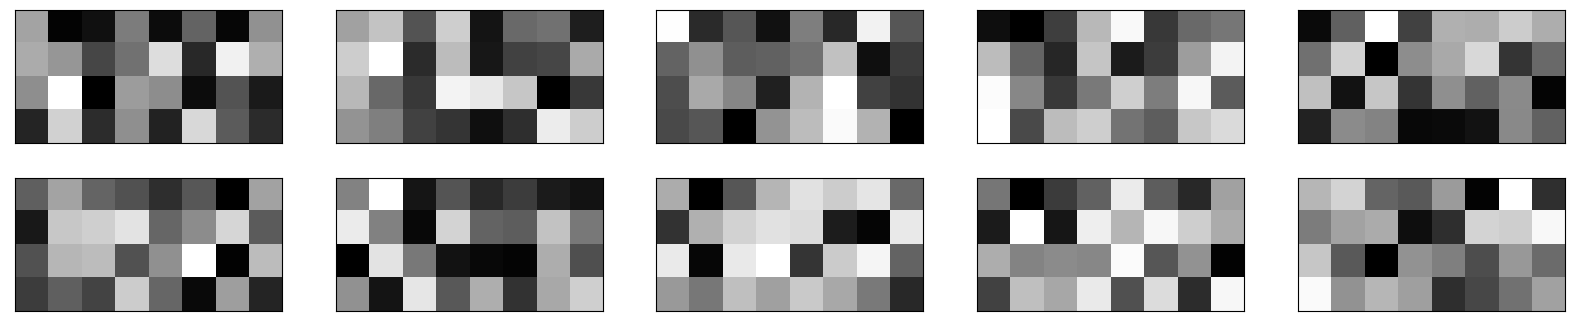

In [33]:
# Displaying the last weights
W = np.asarray(model.layers[1].get_weights()[0])
n_filters = W.shape[3]
print(W.shape)
W = W.reshape((*W.shape[:2], n_filters))
plt.figure(figsize=(20,4))
for i in range(n_filters):
  ax = plt.subplot(2, (n_filters + 1) // 2, i+1)
  plt.imshow(W[:,:,i])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  plt.gray()

In [34]:
predictions = model.predict(x_test)

def top1_error(preds,labels):
  return np.mean(np.argmax(preds,axis=1) != np.argmax(labels,axis=1))

print("Top-1 error is: " + str(top1_error(predictions,y_test[:len(predictions)])))


def top5_error(preds,labels):
  argsorted = np.argsort(np.argsort(preds,axis=1),axis=1)
  arg_of_1 = np.asarray(np.where(labels == 1))
  positions = argsorted[arg_of_1[0],arg_of_1[1]]
  num_of_wrong = np.count_nonzero(positions <= 4)
  return num_of_wrong / len(preds)

def top5_error_for_psychopaths(preds,labels):
  return np.count_nonzero(np.argsort(np.argsort(preds,axis=1),axis=1)[np.asarray(np.where(labels))[0],np.asarray(np.where(labels))[1]] <= 4) / len(preds)



print("Top-5 error is: " + str(top5_error_for_psychopaths(predictions,y_test[:len(predictions)])))

7/7 [==============================] - 3s 442ms/step
Top-1 error is: 0.47
Top-5 error is: 0.095


In [35]:

from collections import Counter
pred_counter = Counter(np.argmax(predictions, axis=1))
true_counter = Counter(np.argmax(y_test, axis=1))
print(pred_counter)
print(true_counter)
from Help import *
def showRandomPredictions(preds,labels):
    maxInd = len(preds)
    print("--------------------------")
    for i in range(5):
        randInd = random.randint(0,maxInd-1)
        onehot = np.zeros(num_classes)
        onehot[np.argmax(preds[randInd])] = 1
        print("Prediction: \t" + str(LabelToGenre(onehot)))
        print("Label:\t\t" + str(LabelToGenre(labels[randInd])))
        print("--------------------------")

showRandomPredictions(predictions,y_test)

--------------------------
Prediction: 	metal
Label:		metal
--------------------------
Prediction: 	country
Label:		country
--------------------------
Prediction: 	classical
Label:		classical
--------------------------
Prediction: 	reggae
Label:		hiphop
--------------------------
Prediction: 	country
Label:		country
--------------------------


Weights:



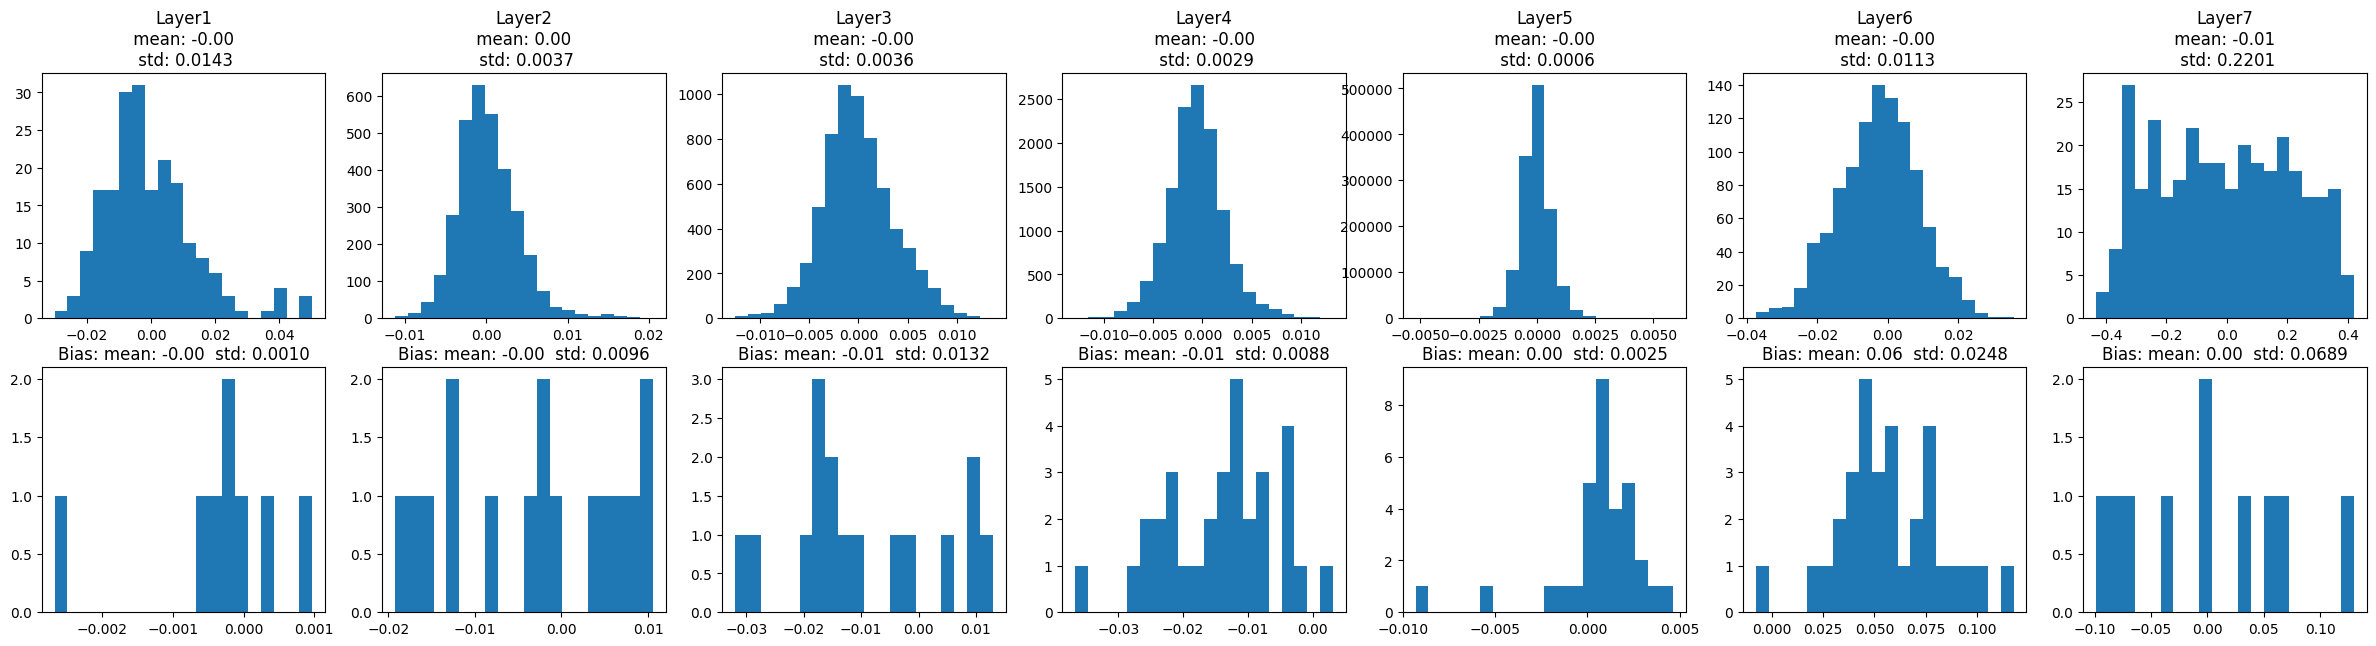

In [36]:
def ShowWeightStats(model):
    print('Weights:\n')
    plt.figure(figsize=(30,7))
    numOfWeightedLayers = 0
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            numOfWeightedLayers = numOfWeightedLayers+1
    i = 1
    for layer in model.layers:
        if len(layer.get_weights()) != 0 and type(layer) != BatchNormalization:
            w = np.asarray(layer.get_weights()[0]).flatten()
            mean = w.mean()
            std = np.std(w)
            b = layer.get_weights()[1]
            meanb = b.mean()
            stdb = np.std(b)
            plt.subplot(2,numOfWeightedLayers,i)
            plt.title("Layer" + str(i) + f"\n mean: {mean:.2f} \n std: {std:.4f}")
            plt.hist(w,bins=20)
            plt.subplot(2,numOfWeightedLayers,i+numOfWeightedLayers)
            plt.title( f"Bias: mean: {meanb:.2f}  std: {stdb:.4f}")
            plt.hist(b,bins=20)
            i = i + 1
    plt.show()
ShowWeightStats(model)




In [38]:
def CalculatePredStats(predictions,labels):
    success = np.zeros(num_classes)
    count_genres = np.zeros(num_classes)
    for i in range(len(labels)):
        count_genres[np.argmax(labels[i])] = count_genres[np.argmax(labels[i])] + 1
        if labels[i][np.argmax(predictions[i])] == 1:
            success[np.argmax(predictions[i])] = success[np.argmax(predictions[i])] + 1
    genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
    for i in range(num_classes):
        print(str(genres[i])+ ":    \t{:.0f} \t {:.0f}%".format(success[i],success[i]*100/count_genres[i]))

CalculatePredStats(predictions,y_test)

blues:    	4 	 19%
classical:    	14 	 82%
country:    	5 	 28%
disco:    	7 	 47%
hiphop:    	18 	 69%
jazz:    	10 	 43%
metal:    	16 	 73%
pop:    	14 	 74%
reggae:    	13 	 57%
rock:    	5 	 31%


In [47]:
# The job is done.
model.save('./Model')

INFO:tensorflow:Assets written to: ./Model\assets


INFO:tensorflow:Assets written to: ./Model\assets
